# Exploring the reference database
Let's see what properties we can find :) <br>
Let's put more data into it !

## TODOs
 - scale frequency spectrum before
 - species level precision (instead of strand level)
 - automate all : 
  - PCA/LDA/Autoencoder/nothing
  - number of bacteria and samples
 - treat plasmids differently
 - try with real Nanopore reads
 - unsupervised learning on all windows into 10 bins ?
 - hierarchical clustering ??
 - clustering with minimal distance
 - taxo id to family or genus
 - tsne plot
 - Add **Visualisation** : https://pandas.pydata.org/pandas-docs/stable/user_guide/visualization.html
 - Save each case, not each run. don't run cases that have already been computed.

## Structure
In `genome/`, there's multiple sub-folder, we will start with `Bacteria`
It then contains all recorded species/strands in individual folders


http://defindit.com/readme_files/ncbi_file_extension_format.html

What we need is the taxo id, name, and the DNA, which can be found in:
 - .gbk for the taxo and name
 - .fna for the sequence

## Coding
### Import and Paths

In [1]:
import os
import pandas as pd
import numpy as np
import pickle
import traceback
import multiprocessing
import random
from datetime import datetime as dt
from time import time
from collections import Counter
from tqdm import tqdm_notebook as tqdm

In [2]:
from sklearn.preprocessing import MinMaxScaler, scale
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sklearn import linear_model
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In [4]:
n_jobs = multiprocessing.cpu_count()

In [ ]:
seed = 84
random.seed(seed)

In [6]:
plt.rcParams['figure.figsize'] = 13, 8

In [7]:
pd.options.display.float_format = '{:,.3f}'.format

In [8]:
path_ref_db = "/home/ubuntu/Data/NCBI/Bacteria_2015/"
path_kmer_freq = "/home/ubuntu/Data/kmer_freq/"

In [9]:
path_4mer = "4mer/V4/"
path_4mer = os.path.join(path_kmer_freq, path_4mer)

In [10]:
path_all = os.path.join("/home/ubuntu/TMP/", "_all_bacteria_4mers_float.largepd")

In [11]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers_float.largepd")

In [ ]:
path_all = os.path.join(path_4mer, "_all_bacteria_4mers.largepd")

In [11]:
path_all

'/home/ubuntu/TMP/_all_bacteria_4mers_float.largepd'

In [12]:
print(f"Found file: {os.path.isfile(path_all)}")

Found file: True


## Main dataset

Load the whole dataset. Will take a while !!

In [13]:
all_df = pd.read_pickle(path_all)

In [14]:
cols_kmers = all_df.columns.to_list()[4:]

In [15]:
cols_spe = sorted(list(set(all_df.columns.to_list()).difference(set(cols_kmers))))

In [22]:
for col in cols_kmers:
    all_df[col] = all_df[col].astype('float32')

In [23]:
path_all = os.path.join("/home/ubuntu/TMP/", "_all_bacteria_4mers_float.largepd")

In [24]:
path_all

'/home/ubuntu/TMP/_all_bacteria_4mers_float.largepd'

In [25]:
all_df.to_pickle(path_all)

In [16]:
all_df.sample(5)

bacteria        fna  len_genome  \
107         Pseudomonas_putida_BIRD_1_uid162055  NC_017530     5731541   
97        Corynebacterium_glutamicum_R_uid58897  NC_009342     3314179   
504     Nocardia_cyriacigeorgica_GUH_2_uid89395  NC_016887     6194645   
187  Leptospirillum_ferrooxidans_C2_3_uid158171  NC_017094     2559538   
408       Escherichia_coli_O7_K1_CE10_uid162115  NC_017646     5313531   

       start   AAAA   AAAC   AAAG   AAAT   AACA   AACC  ...   TTCG   TTCT  \
107  1070000 11.000 15.000 21.000  9.000 18.000 34.000  ... 52.000 25.000   
97    970000 39.000 47.000 27.000 21.000 29.000 38.000  ... 58.000 33.000   
504  5040000  0.000  7.000  5.000  6.000 19.000 28.000  ... 60.000 21.000   
187  1870000 77.000 40.000 58.000 50.000 42.000 51.000  ... 46.000 50.000   
408  4080000 82.000 53.000 58.000 63.000 47.000 38.000  ... 34.000 47.000   

      TTGA   TTGC   TTGG   TTGT   TTTA   TTTC   TTTG    TTTT  
107 39.000 72.000 37.000 21.000  4.000 26.000 18.000  14.000  
97  51.000 51.000 69.000 43.000 18.000 36.000 53.000  34.000  
504 13.000 23.000 23.000 15.000  1.000 12.000  3.000   2.000  
187 37.000 31.000 25.000 36.000  6.000 90.000 30.000  57.000  
408 36.000 55.000 37.000 41.000 59.000 64.000 50.000 115.000  

[5 rows x 260 columns]

normalise per row

In [17]:
row_sums = all_df[cols_kmers].sum(axis=1)

In [18]:
row_sums[row_sums == 0] = 1.0

In [19]:
all_df[cols_kmers] = all_df[cols_kmers].div(row_sums, axis=0)

In [20]:
all_df.isnull().values.any()

False

In [21]:
all_df.sample(5)

bacteria        fna  len_genome  \
74         Dactylococcopsis_salina_PCC_8305_uid183341  NC_019780     3781008   
78              Staphylococcus_aureus_TCH60_uid159859  NC_017342     2802675   
29   Hyphomicrobium_denitrificans_ATCC_51888_uid50325  NC_014313     3638969   
70            Streptococcus_agalactiae_2_22_uid202215  NC_021195     1838867   
484           Pseudomonas_fluorescens_SBW25_uid158693  NC_012660     6722539   

       start  AAAA  AAAC  AAAG  AAAT  AACA  AACC  ...  TTCG  TTCT  TTGA  TTGC  \
74    740000 0.009 0.005 0.005 0.009 0.006 0.005  ... 0.004 0.009 0.007 0.004   
78    780000 0.020 0.007 0.010 0.015 0.011 0.002  ... 0.002 0.002 0.009 0.004   
29    290000 0.002 0.002 0.003 0.001 0.002 0.002  ... 0.010 0.004 0.005 0.006   
70    700000 0.018 0.005 0.009 0.012 0.007 0.002  ... 0.002 0.007 0.010 0.004   
484  4840000 0.001 0.002 0.002 0.000 0.004 0.002  ... 0.006 0.001 0.004 0.007   

     TTGG  TTGT  TTTA  TTTC  TTTG  TTTT  
74  0.005 0.006 0.010 0.011 0.007 0.016  
78  0.004 0.006 0.013 0.004 0.007 0.011  
29  0.002 0.002 0.001 0.007 0.004 0.004  
70  0.007 0.007 0.011 0.007 0.008 0.016  
484 0.003 0.002 0.000 0.003 0.001 0.001  

[5 rows x 260 columns]

In [16]:
unique_bacteria = len(all_df.bacteria.unique())
unique_bacteria

2782

## Reduction possibilities

In [17]:
components = 20
cols_pca = [f"pca_{i+1}" for i in range(components)]
cols_lda = [f"lda_{i+1}" for i in range(components)]

### PCA Principal Component Analysis
Reducing dimension from 256 to ~10

In [24]:
pca = PCA(n_components=components)
pca.fit(all_df[cols_kmers])

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

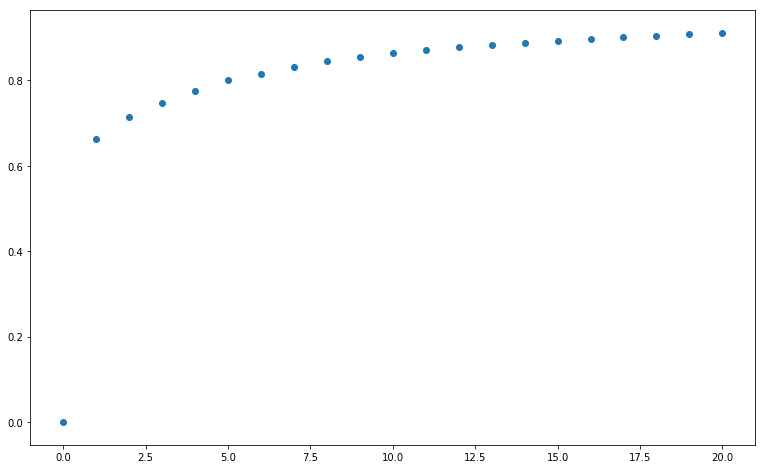

captured by PCA: 91.2%


In [25]:
plt.scatter(x=range(len(pca.explained_variance_ratio_)+1), 
            y=np.insert(pca.explained_variance_ratio_.cumsum(), 0, 0))
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_)*100:0.1f}%")

In [26]:
np_pca = pca.transform(all_df[cols_kmers])
df_pca = pd.DataFrame(np_pca, columns=cols_pca)
df_pca = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_pca], axis=1) # , ignore_index=True)
df_pca["color_map"] = 0
for i, bacteria in enumerate(df_pca.bacteria.unique()):
    df_pca.loc[df_pca["bacteria"] == bacteria, ['color_map']] = i
df_pca.shape

(953798, 25)

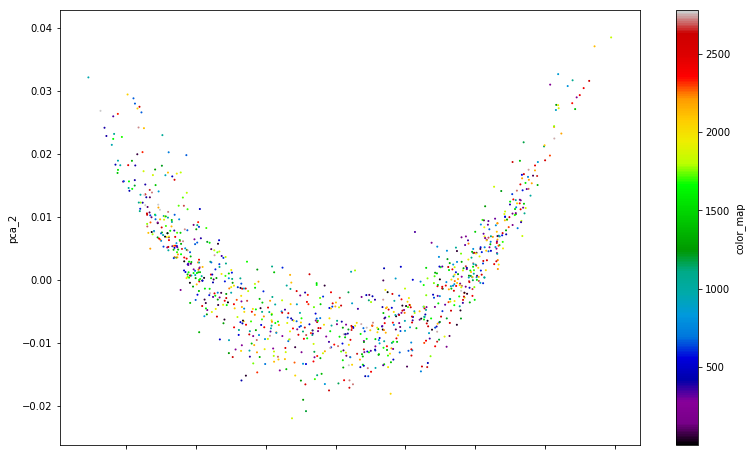

captured by PCA: 71.5%


In [27]:
df_pca.sample(1000).plot.scatter(x="pca_1", y="pca_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by PCA: {sum(pca.explained_variance_ratio_[:2])*100:0.1f}%")

In [28]:
df_pca.sample(3)

bacteria        fna  len_genome  \
913102    Bradyrhizobium_japonicum_USDA_6_uid158851  NC_017249     9207384   
473725  Neisseria_meningitidis_M01_240149_uid162079  NC_017514     2223518   
95389         Desulfovibrio_vulgaris_RCH1_uid161961  NC_017310     3532052   

          start  pca_1  pca_2  pca_3  pca_4  pca_5  pca_6  ...  pca_12  \
913102  8810000 -0.035  0.003 -0.006  0.002  0.010 -0.002  ...  -0.002   
473725  1670000 -0.001 -0.002 -0.009  0.001  0.001 -0.005  ...   0.004   
95389    230000 -0.037 -0.004  0.005  0.001 -0.002  0.002  ...   0.002   

        pca_13  pca_14  pca_15  pca_16  pca_17  pca_18  pca_19  pca_20  \
913102   0.002  -0.001   0.002  -0.001   0.003   0.001  -0.000   0.001   
473725  -0.002   0.004   0.004  -0.004  -0.005   0.001  -0.001  -0.002   
95389   -0.004  -0.008  -0.001  -0.007  -0.003   0.001   0.003  -0.000   

        color_map  
913102       2669  
473725       1386  
95389         294  

[3 rows x 25 columns]

In [18]:
df_pca = pd.read_pickle("/home/ubuntu/TMP/pca_data_953798_20_float.pd")

### LDA Linear Discriminant Analysis
Another dimension reduction, based on labelled data, trying to separate classes as much as possible

In [84]:
lda = LinearDiscriminantAnalysis(n_components=components)
lda.fit(all_df[cols_kmers], all_df.bacteria)
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

captured by LDA: 77.9%


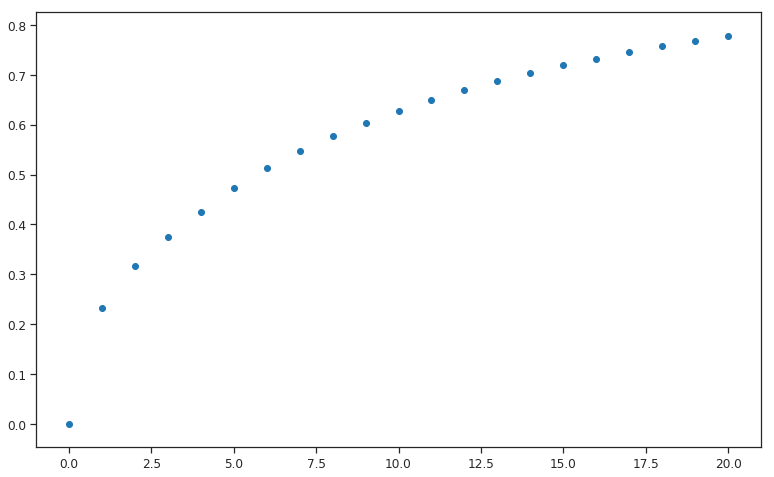

captured by LDA: 77.9%


In [85]:
plt.scatter(x=range(len(lda.explained_variance_ratio_)+1), 
            y=np.insert(lda.explained_variance_ratio_.cumsum(), 0, 0),)
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_)*100:0.1f}%")

In [86]:
np_lda = lda.transform(all_df[cols_kmers])
cols_lda = [f"lda_{i+1}" for i in range(components)]
df_lda = pd.DataFrame(np_lda, columns=cols_lda)
df_lda = pd.concat([all_df[cols_spe].reset_index(inplace=False, drop=True), df_lda], axis=1) # , ignore_index=True)
df_lda["color_map"] = 0
for i, bacteria in enumerate(df_lda.bacteria.unique()):
    df_lda.loc[df_lda["bacteria"] == bacteria, ['color_map']] = i

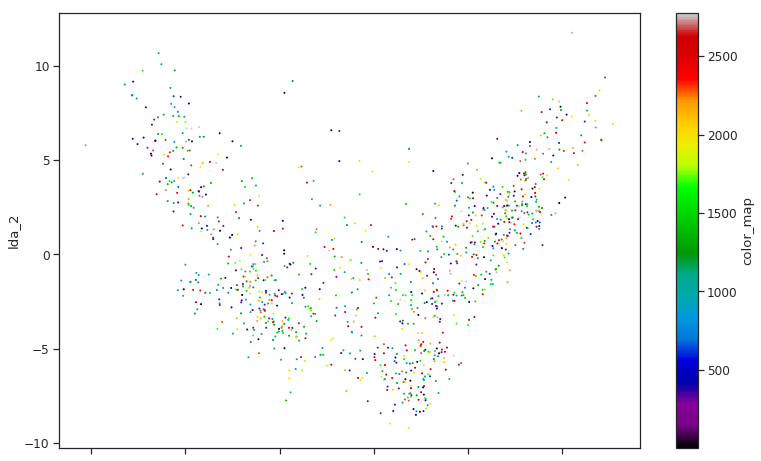

captured by LDA: 31.7%


In [87]:
df_lda.sample(1000).plot.scatter(x="lda_1", y="lda_2", s=1, c="color_map", colormap="nipy_spectral")  # gist_ncar
plt.show()
print(f"captured by LDA: {sum(lda.explained_variance_ratio_[:2])*100:0.1f}%")

In [88]:
df_lda.sample(5)

bacteria        fna  \
654               Chamaesiphon_minutus_PCC_6605_uid183005  NC_019697   
757180             Methanosarcina_barkeri_Fusaro_uid57715  NC_007355   
719732                   Streptococcus_suis_SC84_uid59323  NC_012924   
127772               Mesotoga_prima_MesG1_Ag_4_2_uid52599  NC_017934   
93677   Leisingera_methylohalidivorans_DSM_14336_uid23...  NC_023135   

        len_genome    start  lda_1  lda_2  lda_3  lda_4  lda_5  lda_6  ...  \
654        6284095  3980000  0.589  1.595  5.155  0.004  1.941 -2.923  ...   
757180     4837408  4010000  5.223  0.825 -4.260  0.261  1.978 -1.565  ...   
719732     2095898  1670000  5.183  0.566  0.722 -2.050  3.263 -0.654  ...   
127772     2974229  2940000  1.909  0.252 -3.634  3.578  1.772 -4.253  ...   
93677      4144900  2740000 -2.445 -4.629 -3.611 -2.856  1.053  1.965  ...   

        lda_12  lda_13  lda_14  lda_15  lda_16  lda_17  lda_18  lda_19  \
654     -1.846  -4.565   1.773   1.551   0.068  -3.512  -2.990  -0.047   
757180   1.391   2.437  -0.478  -1.481   0.008   0.311   1.332   0.035   
719732   2.502   1.490  -4.539  -0.854  -0.239  -1.444  -0.900  -0.156   
127772  -2.975   2.393  -0.014  -2.337  -1.799  -0.941   1.845  -0.831   
93677    3.593   0.943   4.667   1.877  -0.846  -2.874   0.277   1.436   

        lda_20  color_map  
654     -2.149          1  
757180   0.813       2220  
719732  -2.159       2112  
127772   1.749        386  
93677    0.938        288  

[5 rows x 25 columns]

In [89]:
df_lda.shape

(953798, 25)

## Functions

In [20]:
def apply_PCA(x, y, components=10):
    cols_pca = [f"pca_{i+1}" for i in range(components)]
    pca = PCA(n_components=components)
    np_pca = pca.fit_transform(x)
    df_pca = pd.DataFrame(np_pca, columns=cols_pca, index=x.index)
    return df_pca, y, sum(pca.explained_variance_ratio_)

In [21]:
def apply_LDA(x, y, components=10):
    cols_lda = [f"lda_{i+1}" for i in range(components)]
    lda = LinearDiscriminantAnalysis(n_components=components)
    np_lda = lda.fit_transform(x, y)
    df_lda = pd.DataFrame(np_lda, columns=cols_lda, index=x.index)
    return df_lda, y, sum(lda.explained_variance_ratio_)

In [22]:
def apply_nothing(x, y, components=None):
    return x, y, 1

In [23]:
dim_reduc = {
    "PCA": apply_PCA,
    "LDA": apply_LDA,
    "raw": apply_nothing,
}

In [24]:
def save_models(path_models, name_run, models, n_classes):
    for model in tqdm(models):
        file_out_path = os.path.join(path_models, f"_{n_classes}_{model}_{name_run}.pkl")
        with open(file_out_path, 'wb') as f_out:
            pickle.dump(models[model], f_out)
            print(f"model {model} saved at {file_out_path}")

In [25]:
def launch_models(models_names, X_train, y_train, X_test, y_test=None, 
                  predict=True, path_models="", name_run="", n_classes=0):
    models = {
        "QDA": QuadraticDiscriminantAnalysis(),
        "Naive_Bayes": GaussianNB(),
        "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=n_jobs),
        "SVM_lin": SVC(kernel="linear", C=0.025),
        "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),   # too slow and memory consumption
        "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=n_jobs),
        "DTree": DecisionTreeClassifier(max_depth=20),
        "NNet": MLPClassifier(alpha=1),    # too slow
        "AdaBoost": AdaBoostClassifier(),  # worse classifier
    }
    results = {}
    for name in tqdm(models_names, disable=False, desc="ML_Models", leave=False, dynamic_ncols=True):
        if name in models.keys():
#             print(name)
            start = time()
            results[name] = {}

            # Train
            models[name].fit(X_train, y_train)
            time_fitted = time()
            results[name]["time_fit"] = time_fitted - start

            if predict:
                # Predict
                predicted = models[name].predict(X_test)
                results[name]["predicted"] = predicted
                time_predicted = time()
                results[name]["time_predict"] = time_predicted - time_fitted

            results[name]["time"] = time() - start
            
            file_out_path = os.path.join(path_models, f"_{n_classes}_{name}_{name_run}.pkl")
            with open(file_out_path, 'wb') as f_out:
                pickle.dump(models[name], f_out)
                print(f"model {name} saved at {file_out_path}")
        
        else:
            models.pop(models)
            
#     if path_models != "" and name_run != "": save_models(path_models, name_run, models, n_classes)
    return results

In [26]:
def pred_accuracy(results, y_test):
    to_df = {"Ground_Truth": y_test}
    for name in results.keys():
        predicted = results[name]["predicted"]
        to_df[f"{name}_pred"] = predicted
        to_df[f"{name}_strand"] = (y_test==predicted).astype(int)
        to_df[f"{name}_species"] = 0
        to_df[f"{name}_genus"] = 0
    pd_res = pd.DataFrame(to_df)

    for name in results.keys():
        # check if the first split of the species name is egal (corresponds to genus level)
        pd_res[f"{name}_genus"] = (pd_res.Ground_Truth.str.split("_", 1).str[0] == \
                                         pd_res[f"{name}_pred"].str.split("_", 1).str[0]).astype(int)
        # Then chec the second, and multiply by the genus (in case some second names are common accross genus)
        pd_res[f"{name}_species"] = ((pd_res.Ground_Truth.str.split("_", 2).str[1] == \
                                            pd_res[f"{name}_pred"].str.split("_", 2).str[1]) \
                                            * pd_res[f"{name}_genus"]).astype(int)
    
    return pd_res

In [27]:
def ranking_ml(pd_res, test_size, results):
    ranking = 100 * pd_res.sum(numeric_only=True) / test_size
    pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                               "percentage": ranking.values})
    for times in ("time", "time_fit", "time_predict", ):
        pd_ranking[times] = 0
        for name in results.keys():
            pd_ranking.loc[pd_ranking["name"].str.contains(name), [times]] = results[name][times]
    return pd_ranking.sort_values(by=["percentage"], ascending=False)

# Pipeline

In [28]:
def run_all_param(df_initial, ml_models, path_4mer=path_4mer, path_models="ml_models/", n_samples=10000, n_bacteria=100,
                  dim_reduc_tool="LDA", components=10, test_ratio=0.1, random_seed=0,):
    
    path_models = os.path.join(path_4mer, path_models)
    if n_bacteria < 0:
        n_bacteria = len(df_initial.bacteria.unique())
        df_down_sampled = df_initial
    else:
        df_down_sampled = df_initial[df_initial.bacteria.isin(df_initial.bacteria.unique()[:n_bacteria])]
    
    if n_samples < 0:
        n_samples = df_down_sampled.shape[0]
    df_down_sampled = df_down_sampled.sample(n_samples, random_state=random_seed)
    test_size = test_ratio * n_samples

    name_run = f"_{dim_reduc_tool}-{'256' if dim_reduc_tool=='raw' else components}" \
               f"_{df_down_sampled.shape[0] if n_samples<0 else n_samples}-samples" \
               f"_{unique_bacteria if n_bacteria<0 else n_bacteria}-bac"
    print(f"\n\n{name_run}")

    y = df_down_sampled["bacteria"]
    x = df_down_sampled[cols_kmers]

    # average each row ?

    x, y, variance_captured = dim_reduc[dim_reduc_tool](x, y, components)
    print(f"Variance captured by {dim_reduc_tool} = {variance_captured*100:.2f}%")

    x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

    results = {}
    try:
        # Save models
        now = dt.now().strftime("%Y-%m-%d_%H-%M")
        results = launch_models(ml_models, X_train, y_train, X_test, y_test, 
                                path_models=path_models, name_run=now, n_classes=n_bacteria)  # name_run
    except Exception as e:
        print("type error: " + str(e))
        print(traceback.format_exc())
        return name_run, results, y_test, variance_captured
        
    pd_res = pred_accuracy(results, y_test)
    pd_res.to_pickle(os.path.join(path_models, f"_{name_run}_results.pd"))

    pd_ranking = ranking_ml(pd_res, test_size, results)
    pd_ranking.to_pickle(os.path.join(path_models, f"_{name_run}_ranking.pd"))
    return name_run, pd_ranking, pd_res, variance_captured

In [29]:
def launch_multiple_cases():
    all_ranking = {}
    all_results = {}
    all_dim_reduc = {}
    guard = 0
    stop = 80

    for n_s in tqdm(sample_sizes, desc="#Sample", dynamic_ncols=True):  # 10000,
        for n_b in tqdm(bacteria_number, desc="#Bacteria", dynamic_ncols=True, leave=False):
            for dim_r in tqdm(dimension_reductions, desc="DimReduc", dynamic_ncols=True, leave=False):  # "raw", 

                # Some combination are not worth or too slow, skip them
                if n_s == 10000 and (n_b <= 0 or 500 < n_b):                 continue
                if dim_r == "raw" and n_s == -1 and (n_b <= 0 or 200 < n_b): continue

                name, pd_ranking, pd_res, variance_captured = \
                    run_all_param(all_all_df, ml_models, n_samples=n_s, n_bacteria=n_b, 
                                  dim_reduc_tool=dim_r, components=20, random_seed=7)

                if not isinstance(pd_ranking, dict): print(pd_ranking[:10])
                all_ranking[name] = pd_ranking
                all_results[name] = pd_res
                all_dim_reduc[name] = variance_captured
                print(pd_ranking[["time_fit", "time_predict"]].describe().loc[["mean"]])

                guard += 1
                if guard>stop: break
            if guard>stop: break
        if guard>stop: break

    path_models = os.path.join(path_4mer, "ml_models/")
    now = dt.now().strftime("%Y-%m-%d_%H-%M")
    with open(os.path.join(path_models, f"_all_results_{now}.pkl"), 'wb') as f: pickle.dump(all_results, f)
    with open(os.path.join(path_models, f"_all_rankings_{now}.pkl"), 'wb') as f: pickle.dump(all_ranking, f)
    print("Finished !")

In [30]:
x = pd.read_pickle(file_lda_data)

In [31]:
x = x[x.bacteria != "Bacteroides_uniformis_uid13130"]

In [32]:
def launch_ml_on_lda_file():
    
    x = pd.read_pickle(file_lda_data)
    print(x.shape)
    # apparently only 1 windows from each of those
    x = x[False == x.bacteria.str.contains('Bacteroides_uniformis_uid13130|' \
                                           'Fusobacterium_nucleatum_polymorphum_ATCC_10953_uid54419')]
    print(x.shape)
    y = x["bacteria"]
    x = pd.DataFrame(scale(x[cols_lda]), index=x.index, columns=cols_lda)
    ml_models = ['QDA', 'Naive_Bayes', 'KNeigh', 'RF',]
    path_models = os.path.join(path_4mer, "ml_models/")

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.0, random_state=12)

    results = {}
    try:
        results = launch_models(ml_models, X_train, y_train, X_test, y_test, predict=False,
                                path_models=path_models, 
                                name_run=dt.now().strftime("%Y-%m-%d_%H-%M"), 
                                n_classes=len(all_all_df.bacteria.unique()))  # name_run
    except Exception as e:
        print("type error: " + str(e))
        print(traceback.format_exc())
    
    return results

In [ ]:
launch_ml_on_lda_file()

(953798, 25)
(953796, 25)


/home/ubuntu/.pyenv/versions/3.7.3/envs/py373/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:692: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


model QDA saved at /home/ubuntu/Data/kmer_freq/4mer/V4/ml_models/_2782_QDA_2019-05-08_17-24.pkl
model Naive_Bayes saved at /home/ubuntu/Data/kmer_freq/4mer/V4/ml_models/_2782_Naive_Bayes_2019-05-08_17-24.pkl
model KNeigh saved at /home/ubuntu/Data/kmer_freq/4mer/V4/ml_models/_2782_KNeigh_2019-05-08_17-24.pkl


# Clustering

https://nbviewer.jupyter.org/github/scikit-learn-contrib/hdbscan/blob/master/notebooks/Comparing%20Clustering%20Algorithms.ipynb

In [19]:
import sklearn.cluster as cluster
import scipy.cluster.hierarchy as sch
import seaborn as sns
import hdbscan
import fastcluster

In [20]:
df_pca.shape

(953798, 26)

In [122]:
x = df_pca.sample(10000)

In [22]:
x.sample(3)

bacteria        fna  len_genome    start  \
239155      Bacillus_subtilis_BSn5_uid62463  NC_014976     4093599   190000   
580138  Bacillus_cereus_ATCC_14579_uid57975  NC_004722     5411809  3860000   
742095       Shigella_sonnei_Ss046_uid58217  NC_007384     4825265  2730000   

        pca_1  pca_2  pca_3  pca_4  pca_5  pca_6  ...  pca_13  pca_14  pca_15  \
239155  0.028 -0.004 -0.003  0.007  0.002 -0.008  ...  -0.001   0.001   0.001   
580138  0.032 -0.004 -0.007  0.018  0.005  0.006  ...  -0.008   0.002  -0.001   
742095  0.006 -0.007 -0.008  0.001 -0.002  0.003  ...   0.001  -0.000   0.002   

        pca_16  pca_17  pca_18  pca_19  pca_20  color_map  cluster  
239155  -0.002   0.004   0.003   0.004   0.000        708        5  
580138   0.004  -0.006  -0.001   0.001   0.004       1708        5  
742095   0.001   0.000  -0.004   0.002   0.000       2179        0  

[3 rows x 26 columns]

In [23]:
now = dt.now().strftime("%Y-%m-%d_%H-%M")

In [24]:
n_clusters = 10

In [26]:
# sns.set_context('poster')
sns.set_context("paper")
# sns.set_context("notebook", font_scale=1.25)
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 10, 'linewidths':0}

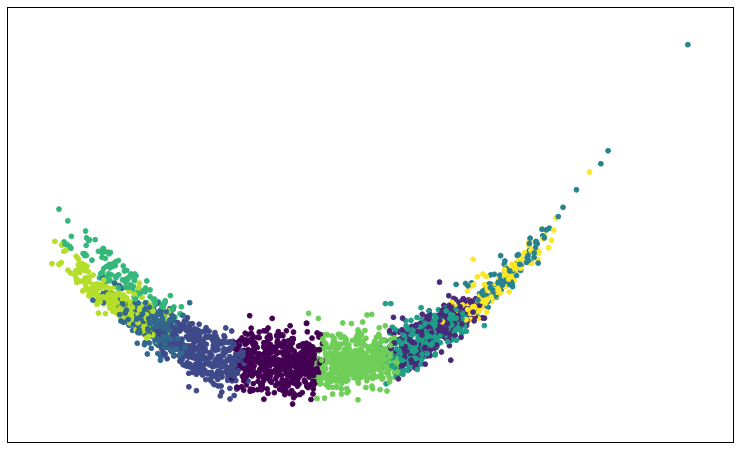

In [27]:
plt.scatter(x.pca_1, x.pca_2, c=x.cluster)  #, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(False)
frame.axes.get_yaxis().set_visible(False)

In [28]:
def compute_clusters(data, algorithm, args, kwds, col_plot=(0,1)):
    start_time = time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time()
    return labels

In [29]:
def plot_clusters(data):
    sample = data.sample(1000)
    
    palette = sns.color_palette('deep', np.unique(sample.cluster).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in sample.cluster]
    
    plot_kwds = {'alpha' : 0.25, 's' : 20, 'linewidths':0}
    
    plt.scatter(sample.pca_1, sample.pca_2, c=colors, **plot_kwds)
#     sns.scatterplot(x=sample.columns[0], y=sample.columns[1], data=sample, legend="full", **plot_kwds)
#     frame = plt.gca()
#     frame.axes.get_xaxis().set_visible(False)
#     frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)

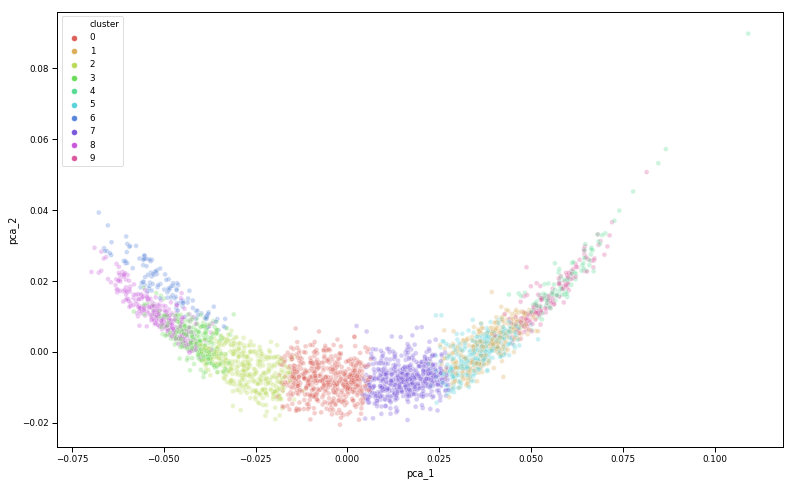

In [30]:
sns.scatterplot(
    x="pca_1", y="pca_2",
    data=x,
    hue="cluster",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)

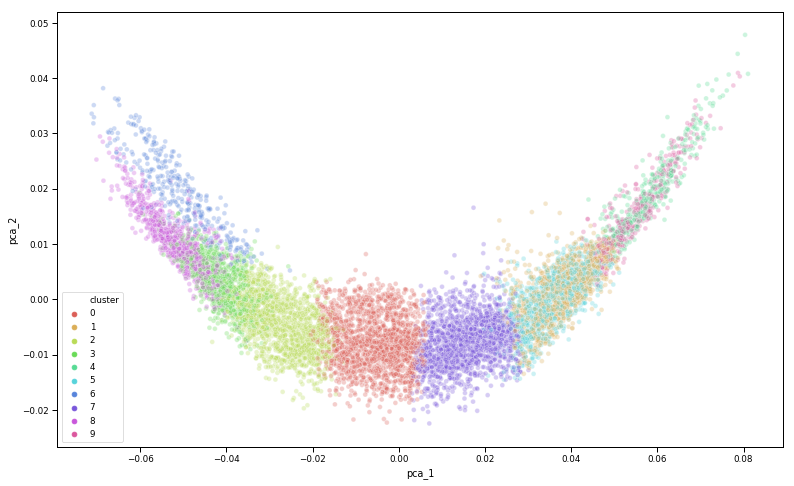

In [193]:
plt.figure()
sns.scatterplot(
    x="pca_1", y="pca_2",
    data=x,
    hue="cluster",
    palette=sns.color_palette("hls", 10),
    legend="full",
    alpha=0.3
)
plt.savefig(f"/home/ubuntu/Data/Presentations/pca_clustered.png")

In [31]:
labels = compute_clusters(df_pca[cols_pca], cluster.MiniBatchKMeans, (), {'n_clusters':10})

In [51]:
df_pca["cluster"] = labels

In [29]:
df_pca.sample(5)

bacteria        fna  \
549896                Bifidobacterium_longum_F8_uid197184  NC_021008   
412131  Aster_yellows_witches_broom_phytoplasma_AYWB_u...  NC_007716   
65880                 Sinorhizobium_fredii_HH103_uid86865  NC_016812   
271317           Haemophilus_influenzae_86_028NP_uid58093  NC_007146   
198466          Mycoplasma_haemofelis_Langford_1_uid62461  NC_014970   

        len_genome    start  pca_1  pca_2  pca_3  pca_4  pca_5  pca_6  ...  \
549896     2384987   650000 -0.023 -0.006 -0.003  0.002  0.002  0.001  ...   
412131      706569   580000  0.072  0.032  0.001 -0.005 -0.010 -0.012  ...   
65880      4305723  2490000 -0.035  0.004 -0.005  0.002  0.006 -0.007  ...   
271317     1914490  1260000  0.035  0.002 -0.007  0.003 -0.003 -0.001  ...   
198466     1147259   730000  0.035 -0.008  0.010  0.011  0.011 -0.005  ...   

        pca_13  pca_14  pca_15  pca_16  pca_17  pca_18  pca_19  pca_20  \
549896  -0.002  -0.002   0.002  -0.004  -0.001  -0.000   0.000  -0.000   
412131   0.005  -0.010   0.004  -0.000  -0.001   0.002   0.001   0.001   
65880    0.002   0.004  -0.002  -0.002  -0.001   0.002   0.002   0.002   
271317  -0.003  -0.002  -0.001   0.000  -0.003  -0.002  -0.001   0.008   
198466  -0.005   0.009   0.005   0.005   0.003   0.004  -0.004  -0.003   

        color_map  cluster  
549896       1625        2  
412131       1213        4  
65880         198        3  
271317        806        5  
198466        595        5  

[5 rows x 26 columns]

In [45]:
x.shape

(3000, 26)

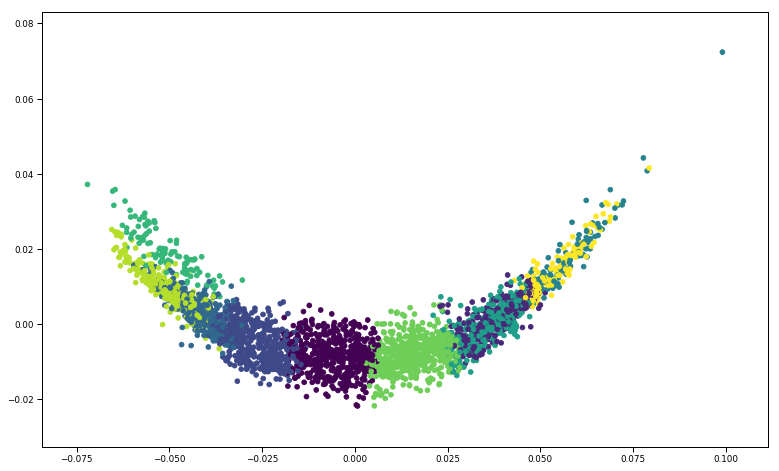

In [30]:
plt.scatter(x.pca_1, x.pca_2, c=x.cluster)

Learn the clusters

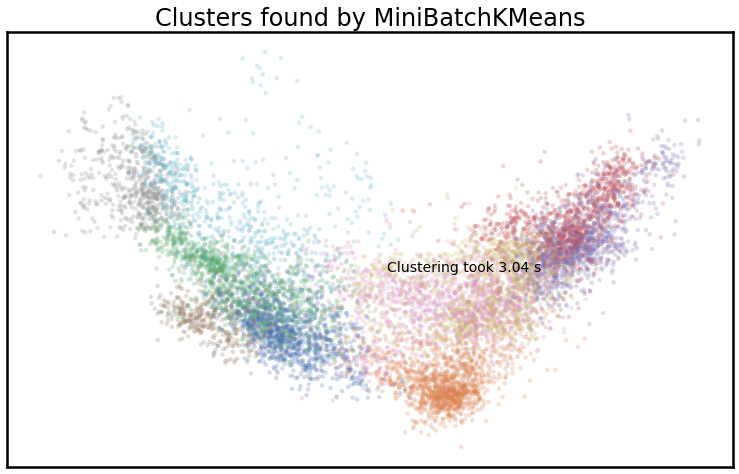

In [41]:
labels = plot_clusters(x[cols_lda], cluster.MiniBatchKMeans, (), {'n_clusters':10})

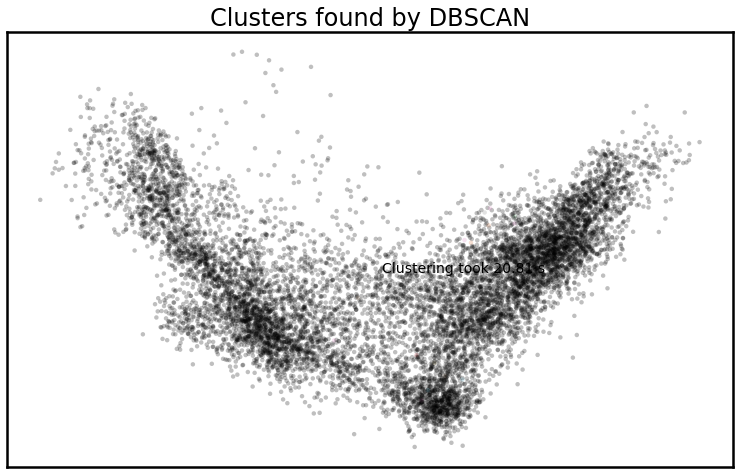

In [162]:
plot_clusters(x[cols_lda], cluster.DBSCAN, (), {'eps':0.025})

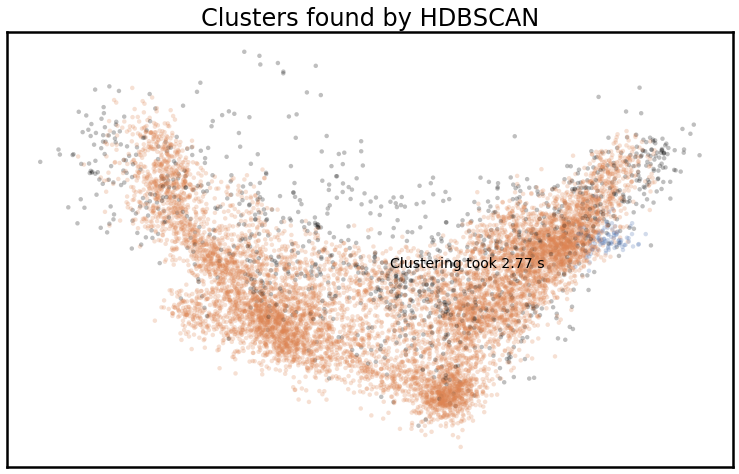

In [158]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':50})

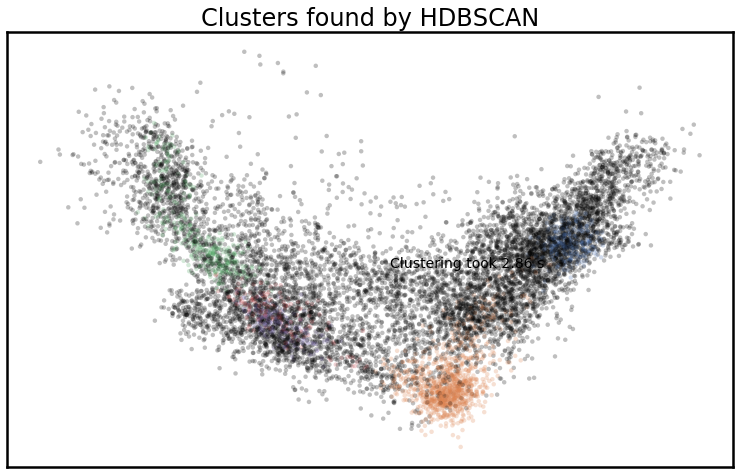

In [161]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':100})

In [ ]:
plot_clusters(pd_scaled, hdbscan.HDBSCAN, (), {'min_cluster_size':100})

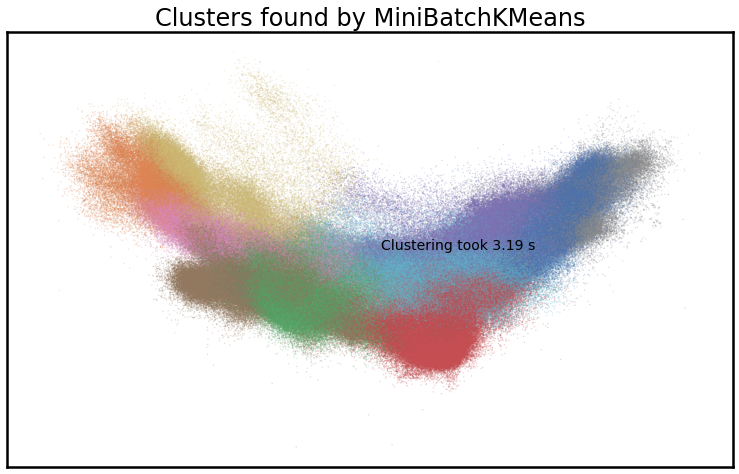

In [130]:
plot_clusters(x[cols_lda], cluster.MiniBatchKMeans, (), {'n_clusters':10})

## t-SNE

In [32]:
subset = df_pca.sample(5000)

In [36]:
perplexity=70
n_iter=1000

In [31]:
X_embedded = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter).fit_transform(subset[cols_pca])
X_embedded.shape

[t-SNE] Computing 211 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.006s...
[t-SNE] Computed neighbors for 5000 samples in 0.737s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.007545
[t-SNE] KL divergence after 250 iterations with early exaggeration: 68.330856
[t-SNE] KL divergence after 1000 iterations: 1.180108


(5000, 2)

In [32]:
tsne_df = pd.DataFrame(X_embedded, columns=["component1", "component2"])

In [33]:
subset["component1"] = X_embedded[:,0]
subset["component2"] = X_embedded[:,1]

In [115]:
def compute_tsne(data, labels, perplexity=30, n_iter=1000):
    X_embedded = TSNE(n_components=2, verbose=1, perplexity=perplexity, n_iter=n_iter).fit_transform(data)
    tsne_df = pd.DataFrame(X_embedded, columns=["component1", "component2"], index=data.index)
    tsne_df["cluster"] = labels
#     data["component1"] = X_embedded[:,0]
#     data["component2"] = X_embedded[:,1]
    return tsne_df

In [42]:
def save_plot_tsne(tsne_df, perplexity):
    plt.figure()
    ax = sns.scatterplot(
            x="component1", y="component2",
            data=tsne_df,
            hue="cluster",
            palette=sns.color_palette("hls", 10),
            legend="full",
            alpha=0.3,
    )
    ax.set_title(f"t-SNE with perplexity:{perplexity} and n_iter={n_iter}")
    plt.savefig(f"/home/ubuntu/Data/Presentations/Clustering_t-SNE/plot-perplexity_{perplexity:03}-n_iter_{n_iter:04}.png")
    print(f"Saved figure: plot-perplexity_{perplexity:03}-n_iter_{n_iter:04}.png")
    # plt.show()

In [95]:
tsne_df.sample(10)

component1  component2  cluster
82      -0.807       1.301      nan
1       -0.803       1.300      nan
74      -0.808       1.302      nan
95      -0.802       1.300      nan
40      -0.803       1.307      nan
91      -0.808       1.302      nan
19      -0.802       1.302      nan
97      -0.804       1.299      nan
37      -0.807       1.306      nan
88      -0.809       1.303      nan

[t-SNE] Computing 7 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.064s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.002717
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.380478
[t-SNE] KL divergence after 1000 iterations: 1.005970
Saved figure: plot-perplexity_002-n_iter_1000.png
[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 2000 samples in 0.002s...
[t-SNE] Computed neighbors for 2000 samples in 0.090s...
[t-SNE] Computed conditional probabilities for sample 1000 / 2000
[t-SNE] Computed conditional probabilities for sample 2000 / 2000
[t-SNE] Mean sigma: 0.004615
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.469612
[t-SNE] KL divergence after 1000 iterations: 1.129057
Saved figure: plot-perplexity_005-n_iter_1000.png
[t-SNE] Computing 31 nearest neig

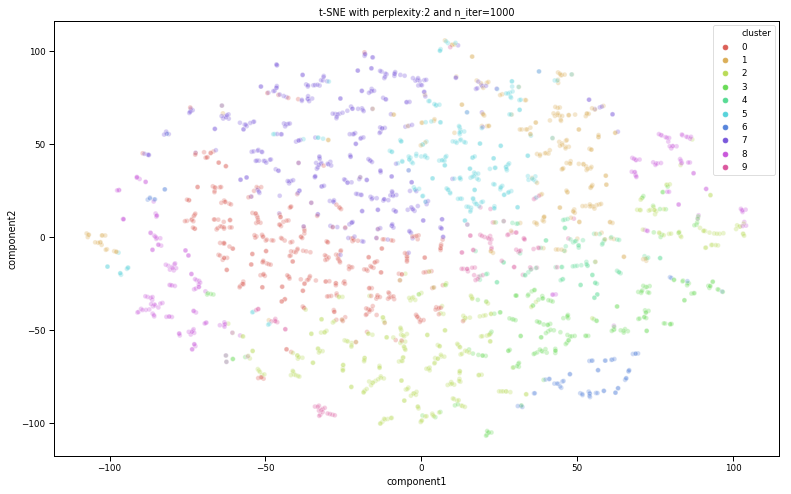

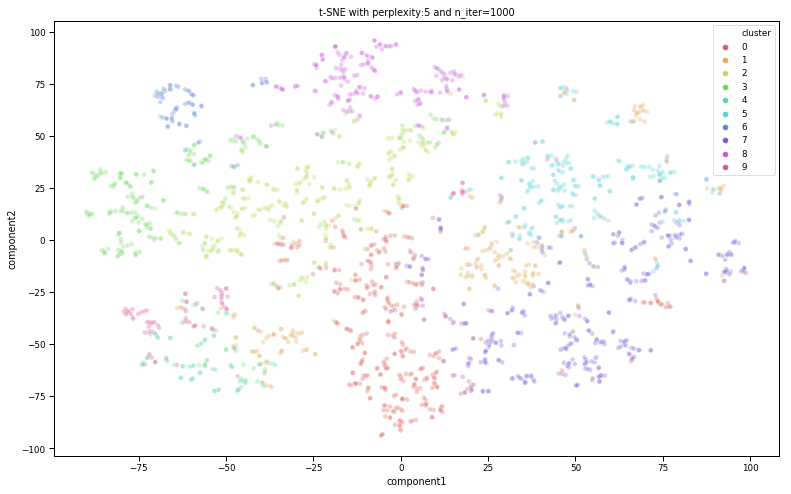

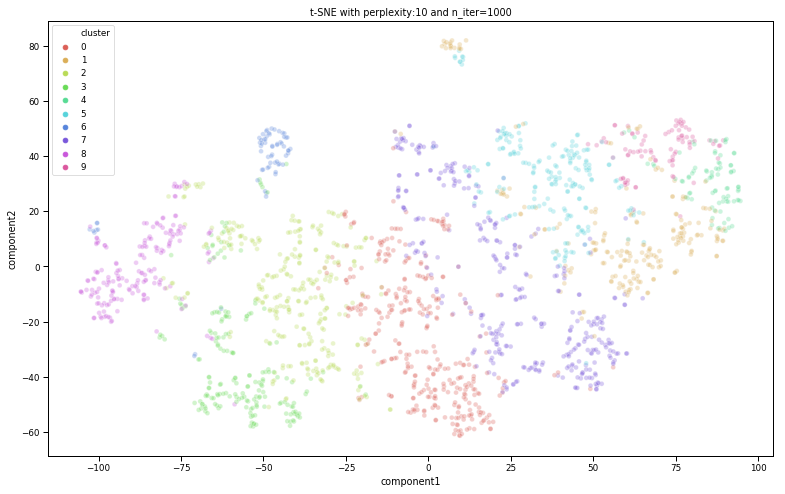

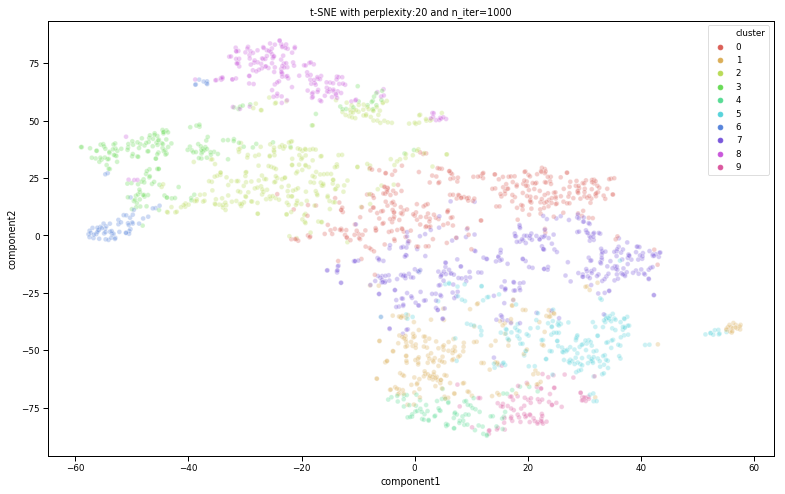

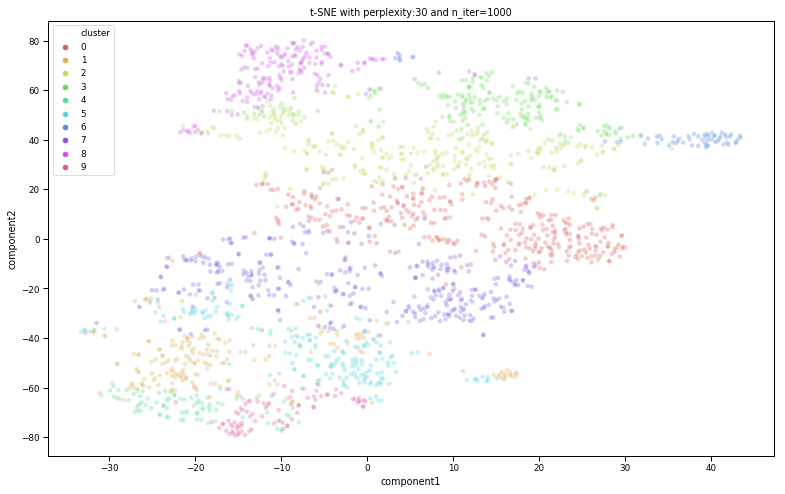

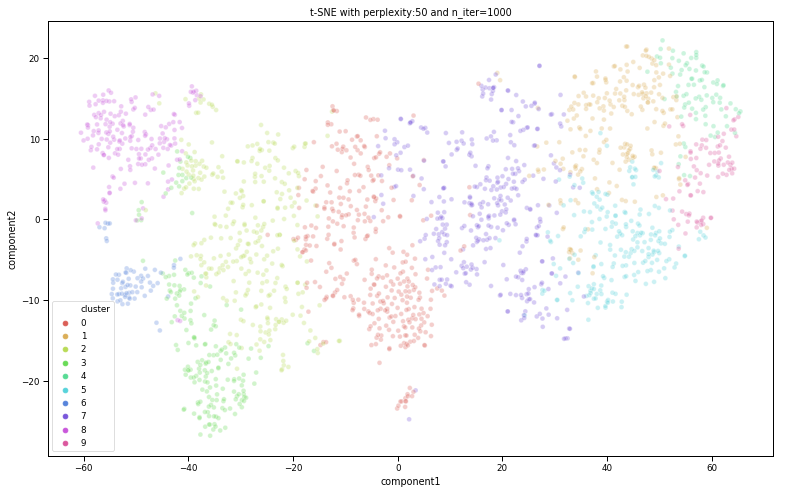

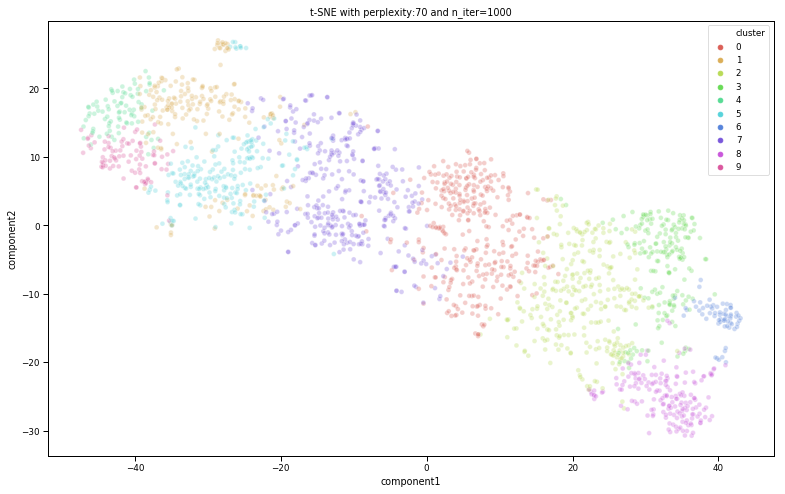

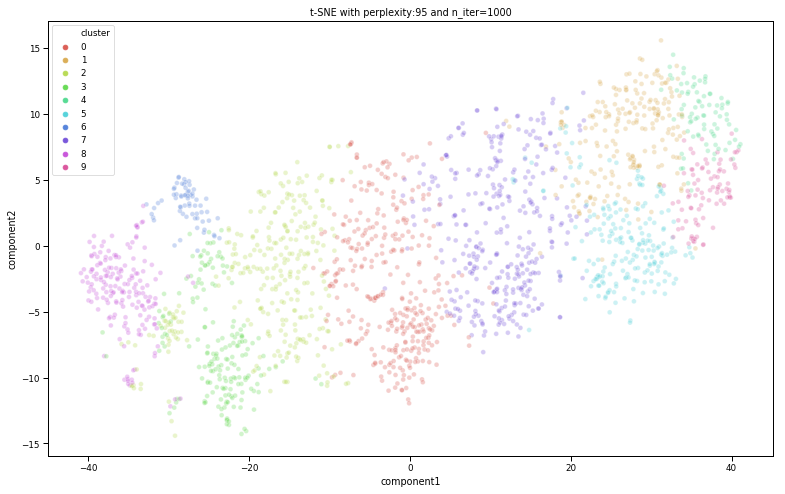

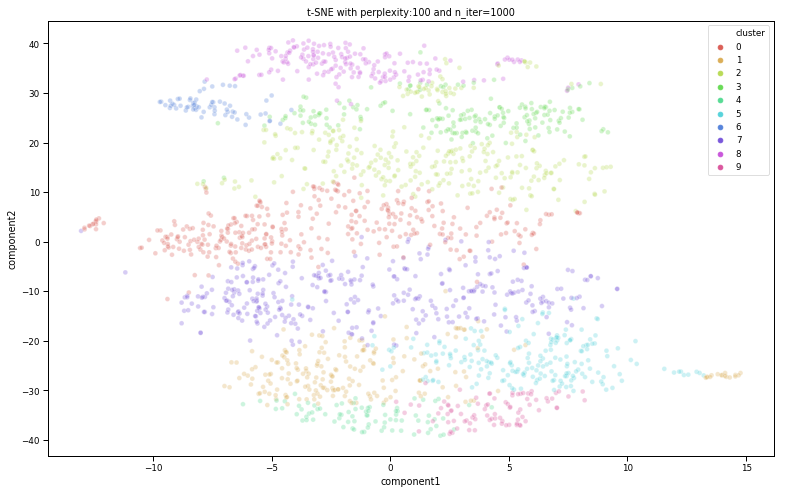

In [118]:
dat = df_pca.sample(2000)
n_iter=1000
for perplex in tqdm([2, 5, 10, 20, 30, 50, 70, 95, 100]):
    tsne_df = compute_tsne(dat[cols_pca], dat[["cluster"]], perplexity=perplex)
    save_plot_tsne(tsne_df, perplex)

## Checking if clusters make sense

In [170]:
x = df_pca.sample(10000)

In [124]:
x.sample(10)

bacteria        fna  \
632070             Pseudomonas_monteilii_SB3078_uid232252  NC_023075   
248758              Marivirga_tractuosa_DSM_4126_uid60837  NC_014759   
370891  Bacillus_amyloliquefaciens_plantarum_UCMB5113_...  NC_022081   
558104                    Pseudomonas_fulva_12_X_uid67351  NC_015556   
587482                    Aeromonas_veronii_B565_uid66323  NC_015424   
409780        Acinetobacter_baumannii_BJAB07104_uid210971  NC_021726   
737095            Mycobacterium_liflandii_128FXT_uid59005  NC_020133   
202444                      Clostridium_novyi_NT_uid58643  NC_008593   
415355                          Burkholderia_383_uid58073  NC_007510   
714853           Herbaspirillum_seropedicae_SmR1_uid50427  NC_014323   

        len_genome    start  pca_1  pca_2  pca_3  pca_4  pca_5  pca_6  ...  \
632070     6000087   340000 -0.025 -0.010 -0.003 -0.002 -0.013 -0.001  ...   
248758     4511574  3230000  0.044  0.004  0.003  0.003 -0.002 -0.007  ...   
370891     3889532  3220000  0.015 -0.003 -0.004  0.010  0.005 -0.009  ...   
558104     4920769  1620000 -0.033 -0.006 -0.005 -0.001 -0.012  0.000  ...   
587482     4551783  1470000 -0.019 -0.013  0.007 -0.001 -0.005 -0.003  ...   
409780     3951920  1260000  0.034 -0.005 -0.001 -0.012 -0.002  0.003  ...   
737095     6208955  3940000 -0.031 -0.006  0.001  0.001 -0.001  0.006  ...   
202444     2547720  1640000  0.057  0.017  0.005  0.021 -0.006  0.004  ...   
415355     3694126    30000 -0.038  0.007 -0.014  0.002  0.011  0.000  ...   
714853     5513887  4790000 -0.021 -0.007 -0.002 -0.002 -0.003 -0.004  ...   

        pca_13  pca_14  pca_15  pca_16  pca_17  pca_18  pca_19  pca_20  \
632070   0.000  -0.004   0.002  -0.002  -0.003  -0.003  -0.001  -0.000   
248758  -0.001  -0.003   0.001   0.002   0.001   0.002  -0.002   0.002   
370891  -0.000   0.004  -0.003  -0.002   0.004   0.004   0.005   0.004   
558104   0.004  -0.001   0.002   0.001  -0.001   0.003   0.002   0.002   
587482   0.005  -0.003   0.001  -0.000   0.006   0.002  -0.000  -0.001   
409780  -0.002   0.003   0.001   0.002   0.003   0.001   0.003   0.002   
737095   0.002  -0.002  -0.001  -0.001   0.001  -0.001  -0.004   0.001   
202444   0.000  -0.003  -0.002  -0.003  -0.004  -0.005  -0.002  -0.002   
415355  -0.000  -0.003   0.000  -0.002  -0.001  -0.001  -0.001   0.002   
714853  -0.002  -0.003   0.004   0.001  -0.002  -0.004   0.002  -0.002   

        color_map  cluster  
632070       1855        2  
248758        737        5  
370891       1085        7  
558104       1647        3  
587482       1727        2  
409780       1206        1  
737095       2165        2  
202444        609        9  
415355       1221        6  
714853       2100        2  

[10 rows x 26 columns]

In [136]:
df_pca.sample(3)

bacteria        fna  len_genome  \
639716    Streptococcus_pyogenes_MGAS1882_uid158061  NC_017053     1781029   
670062                Mycobacterium_JDM601_uid67369  NC_015576     4643668   
219505  Echinicola_vietnamensis_DSM_17526_uid184076  NC_019904     5608040   

          start  pca_1  pca_2  pca_3  pca_4  pca_5  pca_6  ...  pca_14  \
639716  1580000  0.034 -0.004  0.001  0.004 -0.000 -0.004  ...   0.001   
670062  1020000 -0.047  0.005  0.003 -0.001 -0.002  0.006  ...   0.004   
219505  4140000  0.025 -0.009  0.005 -0.001 -0.003 -0.003  ...  -0.004   

        pca_15  pca_16  pca_17  pca_18  pca_19  pca_20  color_map  cluster  \
639716   0.001  -0.001   0.003   0.000   0.001  -0.004       1874        5   
670062   0.002  -0.001  -0.000   0.000  -0.003  -0.001       1966        8   
219505   0.001  -0.001  -0.001  -0.001   0.001   0.000        655        7   

        genome_plasmid  
639716             NaN  
670062             NaN  
219505             NaN  

[3 rows x 27 columns]

In [134]:
df_pca["genome_plasmid"] = "NaN"

In [161]:
# add label for genome itself, and plasmid for the others
for bac in tqdm(df_pca.bacteria.unique()):
    genome_length = df_pca[df_pca.bacteria == bac].len_genome.unique().max()
    df_pca.loc[(df_pca.bacteria == bac) & (df_pca.len_genome == genome_length), 
               "genome_plasmid"] = "genome"
    df_pca.loc[(df_pca.bacteria == bac) & (df_pca.len_genome != genome_length), 
               "genome_plasmid"] = "plasmid"

In [168]:
df_pca[["bacteria", "len_genome", "genome_plasmid"]].sample(20)

bacteria  len_genome  \
819442                     Oenococcus_oeni_PSU_1_uid59417     1780517   
297786                  Shigella_flexneri_2a_301_uid62907     4607202   
802944         Acinetobacter_baumannii_BJAB0868_uid210973     3906795   
410865          Oligotropha_carboxidovorans_OM4_uid162135     3539447   
15611              Actinosynnema_mirum_DSM_43827_uid58951     8248144   
547285     Fervidobacterium_pennivorans_DSM_9078_uid78143     2166381   
19406              Clostridium_botulinum_Ba4_657_uid59173     3977794   
585717                       Sphingobacterium_21_uid64755     6226409   
60818   Francisella_tularensis_mediasiatica_FSC147_uid...     1893886   
613532                         Burkholderia_YI23_uid81081     1773019   
183376       Mycobacterium_tuberculosis_KZN_1435_uid59069     4398250   
868672               Octadecabacter_arcticus_238_uid54699     5200279   
452230              Pseudomonas_aeruginosa_RP73_uid209328     6342034   
89065                      Pseudomonas_putida_F1_uid58355     5959964   
290543          Burkholderia_pseudomallei_K96243_uid57733     3173005   
790733               Aromatoleum_aromaticum_EbN1_uid58231     4296230   
545613   Vibrio_cholerae_O1_biovar_El_Tor_N16961_uid57623     2961149   
262370          Lactobacillus_rhamnosus_LOCK908_uid210958     2990900   
951693       Streptomyces_fulvissimus_DSM_40593_uid201038     7905758   
773054           Clostridium_botulinum_F_230613_uid159513     3993083   

       genome_plasmid  
819442         genome  
297786         genome  
802944         genome  
410865         genome  
15611          genome  
547285         genome  
19406          genome  
585717         genome  
60818          genome  
613532        plasmid  
183376         genome  
868672         genome  
452230         genome  
89065          genome  
290543        plasmid  
790733         genome  
545613         genome  
262370         genome  
951693         genome  
773054         genome

In [188]:
def windows_counts_plot():
    # computing values
    x_val = []
    y_val = []
    bac_name = []
    plot_x = 3; plot_y = 4
    nb_examples = plot_x * plot_y
    for bac in random.choices(df_pca.bacteria.unique(), k=nb_examples):
        clusters = Counter(df_pca[(df_pca.bacteria == bac) & (df_pca.genome_plasmid == "genome")].cluster)
        clusters = dict(clusters)
        for key in range(10):
            if key not in clusters.keys():
                clusters[key] = 0
        x_val.append(list(clusters.keys()))
        y_val.append(list(clusters.values()))
        bac_name.append(bac)
    
    # plotting
    plt.figure()
    for i in range(nb_examples):
        plt.subplot(plot_x, plot_y, i+1)
        sns.barplot(x_val[i], y_val[i])
        plt.title("_".join(bac_name[i].split("_")[0:2]))

        if i+1 == 10: plt.xlabel("Cluster ID")
        if i+1 == 5: plt.ylabel("# windows assigned")

        if i+1 >= 9: plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
        else:        plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)


In [189]:
sns.set_context("paper")
# sns.set_context("notebook", font_scale=1.25)
# sns.set_color_codes()
# plot_kwds = {'alpha' : 0.25, 's' : 2, 'linewidths':0}

Saved figure: 00.png
Saved figure: 01.png
Saved figure: 02.png
Saved figure: 03.png
Saved figure: 04.png
Saved figure: 05.png
Saved figure: 06.png
Saved figure: 07.png
Saved figure: 08.png
Saved figure: 09.png


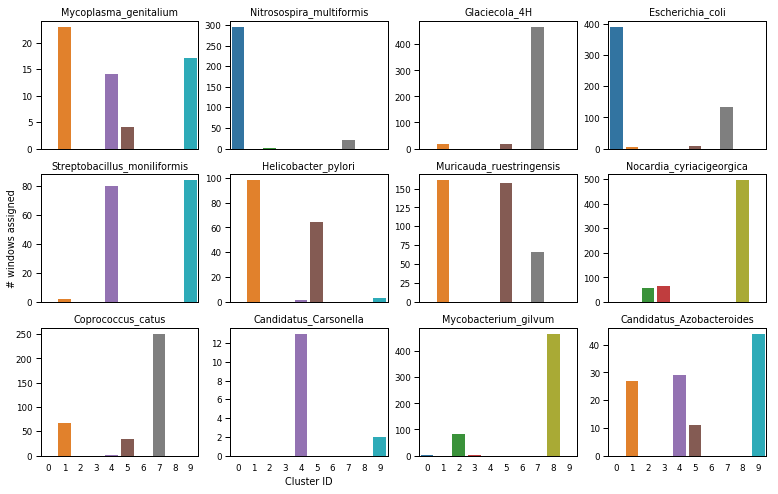

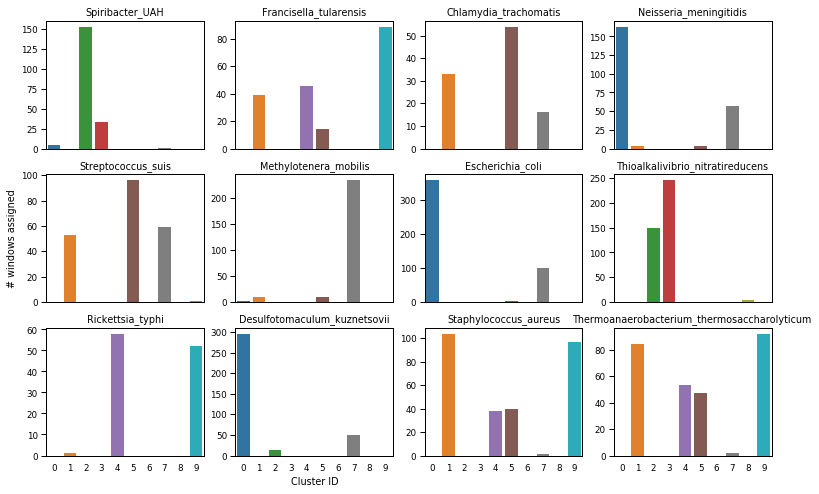

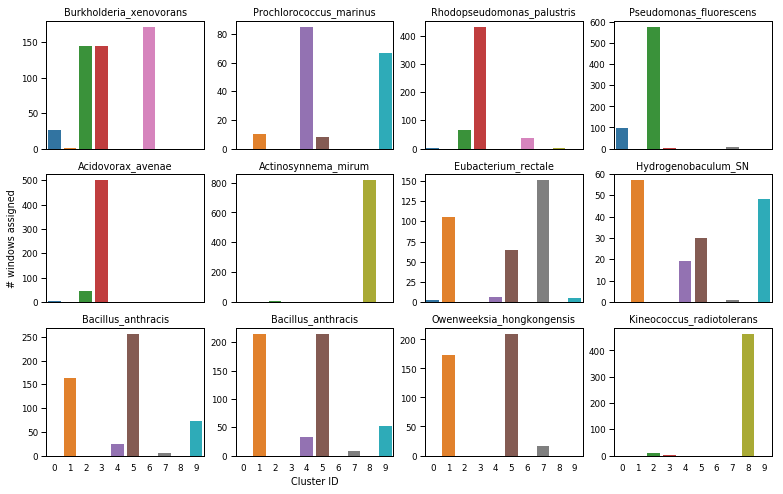

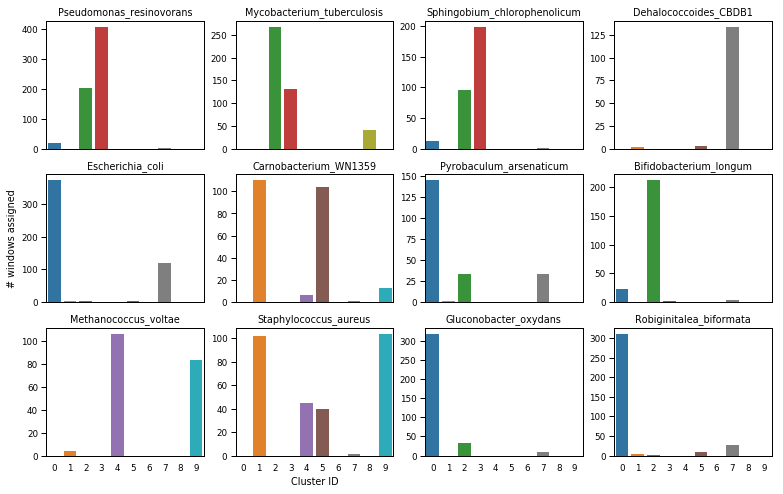

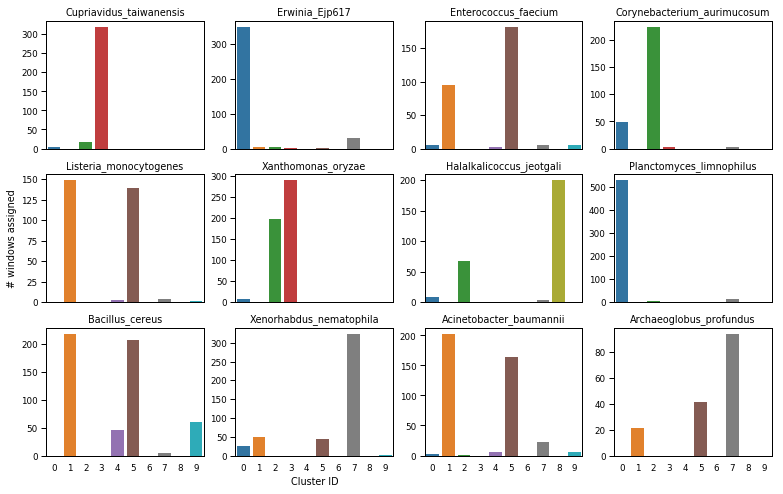

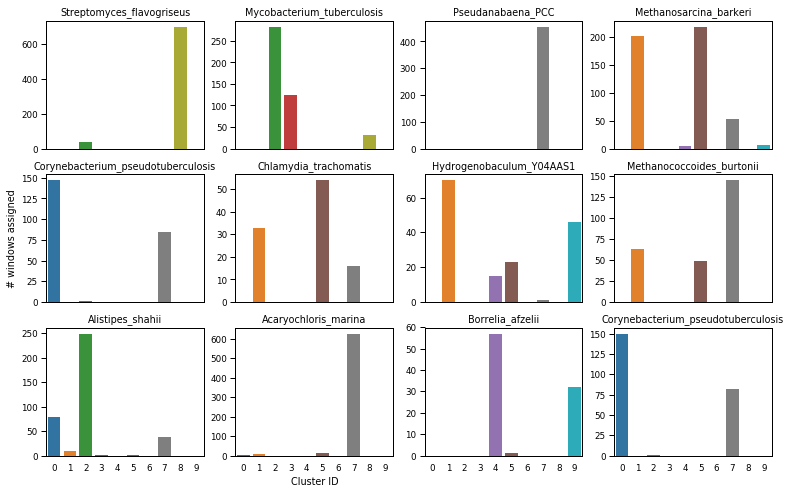

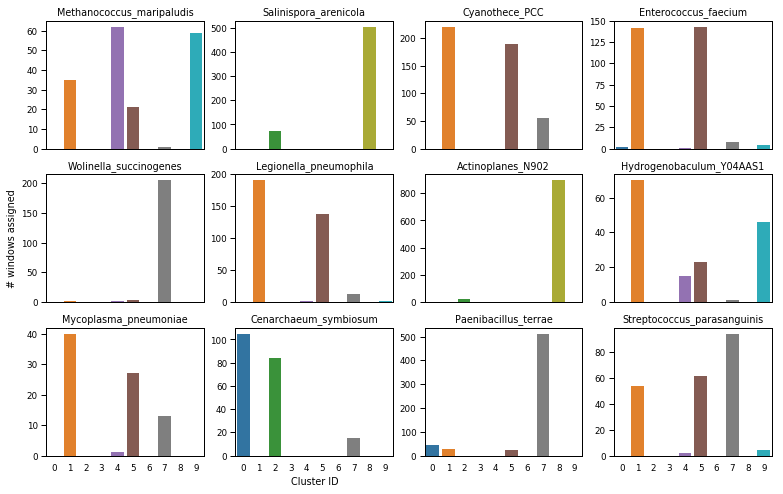

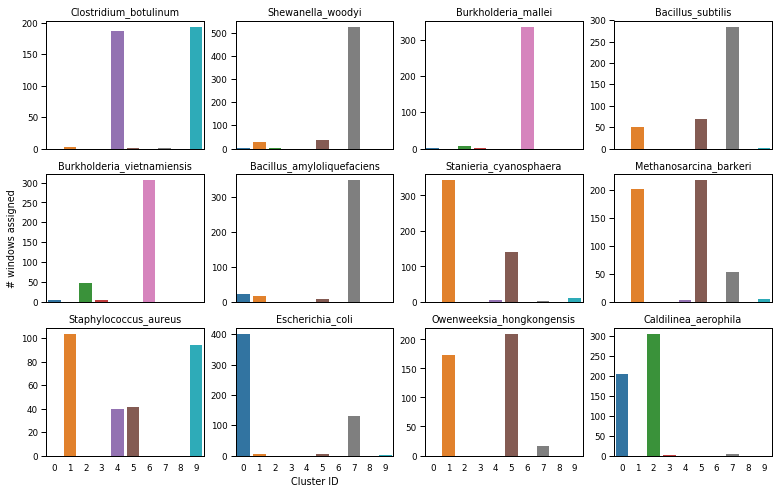

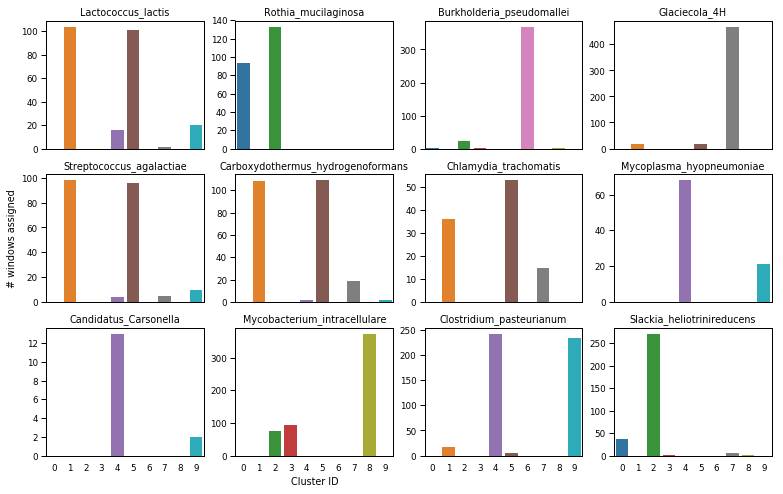

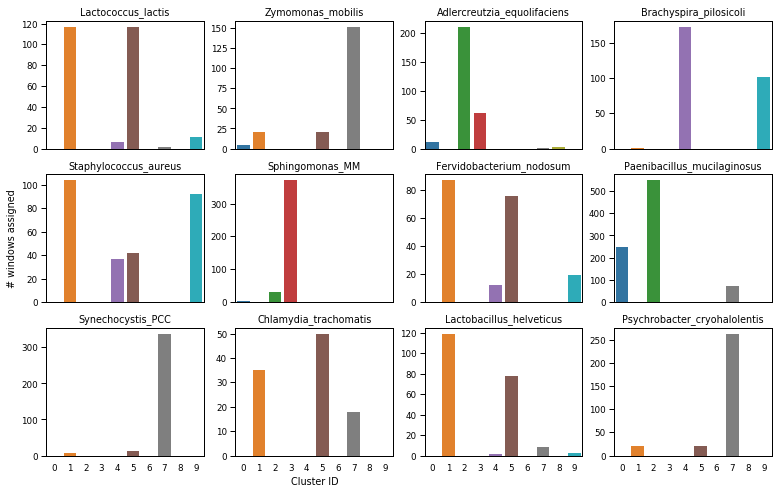

In [190]:
for i in tqdm(range(10)):
    windows_counts_plot()
    plt.savefig(f"/home/ubuntu/Data/Presentations/genomes_window_counts/{i:02}.png")
    print(f"Saved figure: {i:02}.png")

## K Means

In [94]:
kmeans = KMeans(n_clusters=n_clusters, n_jobs=-1, random_state=seed)

In [95]:
kmeans.fit(x[cols_lda])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=10, n_init=10, n_jobs=-1, precompute_distances='auto',
    random_state=84, tol=0.0001, verbose=0)

In [96]:
y_km = kmeans.predict(x[cols_lda])

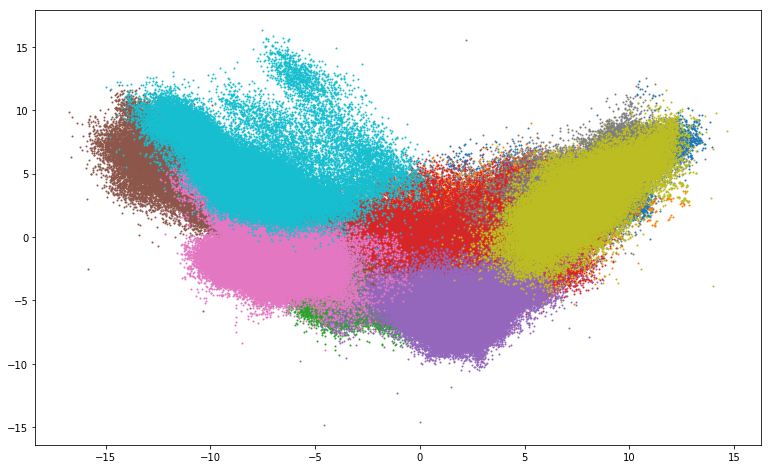

In [97]:
for c in range(n_clusters):
    plt.scatter(x["lda_1"][y_km == c], x["lda_2"][y_km == c], s=1)

In [98]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_kmeans_{now}.pkl", 'wb') as f: 
    pickle.dump(kmeans, f)

## Agglomerate clustering

In [77]:
data = x[cols_lda].sample(10000)

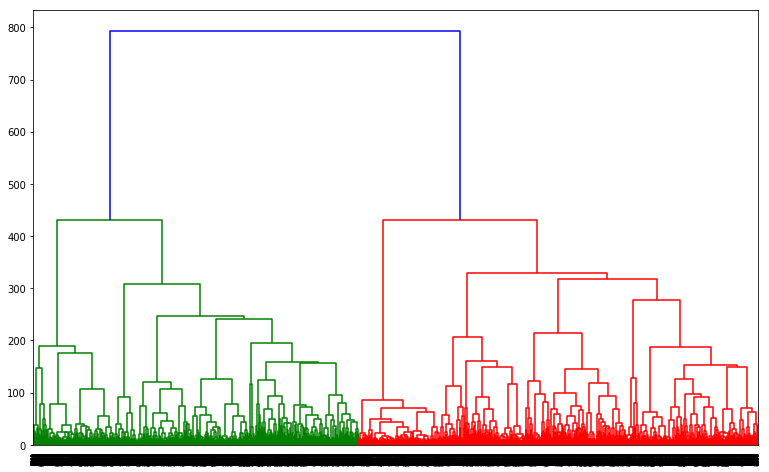

In [78]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
# create clusters
print("Create clusters...")
hc = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
print("save them")
y_hc = hc.fit_predict(data)

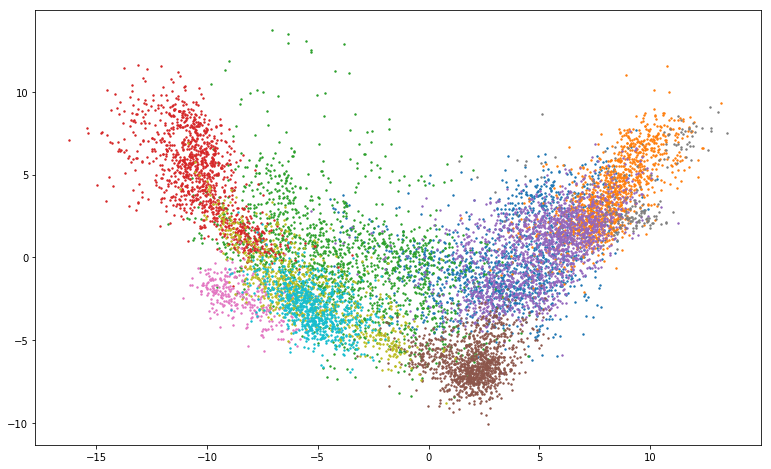

In [81]:
for c in range(n_clusters):
    plt.scatter(data["lda_1"][y_hc == c], data["lda_2"][y_hc == c], s=2)

In [85]:
with open(f"/home/ubuntu/Data/kmer_freq/4mer/V4/clustering/{n_clusters}_agglo_{now}.pkl", 'wb') as f: 
    pickle.dump(hc, f)

## Mini Batch KMeans

In [99]:
minikm = MiniBatchKMeans(n_clusters=n_clusters, random_state=seed, batch_size=1000, max_iter=100)

In [100]:
minikm.fit(x[cols_lda])

MiniBatchKMeans(batch_size=1000, compute_labels=True, init='k-means++',
        init_size=None, max_iter=100, max_no_improvement=10, n_clusters=10,
        n_init=3, random_state=84, reassignment_ratio=0.01, tol=0.0,
        verbose=0)

In [101]:
y_mini = minikm.predict(x[cols_lda])

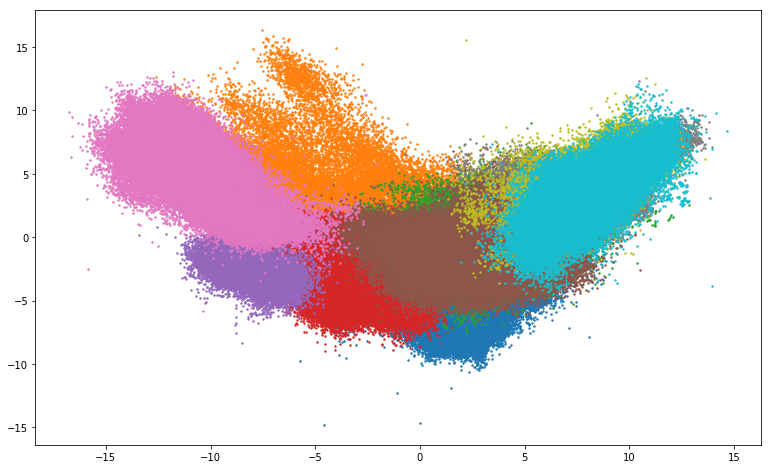

In [102]:
for c in range(n_clusters):
    plt.scatter(x["lda_1"][y_mini == c], x["lda_2"][y_mini == c], s=2)

## Combining results

In [104]:
class Cluster:
    def __init__(self, name, model, prediction):
        self.name = name
        self.model = model
        self.pred = prediction
        

In [105]:
models = [
    Cluster("kmeans", kmeans, y_km),
    Cluster("agglo", hc, y_hc),
    Cluster("minikm", minikm, y_mini),
]

# Evaluation

In [113]:
[len(model.pred) for model in models]

[953797, 10000, 953797]

In [110]:
pd_pred = pd.DataFrame({
    model.name: model.pred for model in models
})

ValueError: arrays must all be same length



### End of the script.
Sylvain @GIS

In [ ]:
ranking_ml(pd_res, 1000)

In [ ]:
pd_res

In [ ]:
pd_res[f"RF_pred"].str.split("_", 2).str[1]

In [ ]:
pd_res.Ground_Truth.str.split("_", 1).str[0] == pd_res[f"RF_pred"].str.split("_", 1).str[0]

In [ ]:
pd_res.Ground_Truth == pd_res[f"RF_pred"]

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
n_samples = 10000
n_bacteria = 100
random_seed = 0
dim_reduc_tool = "PCA"
components = 10
test_ratio = 0.1

In [ ]:
name_run = f"_{dim_reduc_tool}-{components}_{n_samples}-samples_{n_bacteria}-bac"

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
y = all_df["bacteria"]
x = all_df[cols_kmers]

In [ ]:
# average each row ?

In [ ]:
x, y = dim_reduc[dim_reduc_tool](x, y, components)

In [ ]:
x = pd.DataFrame(scale(x), index=x.index, columns=x.columns)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_ratio, random_state=random_seed)

In [ ]:
models_names = ['RF', 'SVM_lin', 'SVM_rbf', 'KNeigh', 'DTree', 'NNet', 'Naive_Bayes', 'QDA']

In [ ]:
results = launch_models(models_names, X_train, y_train, X_test, y_test, path_models, )  # name_run

In [ ]:
pd_res = pred_accuracy(results, y_test)
pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
pd_res.shape

In [ ]:
pd_ranking = ranking_ml(pd_res, test_ratio * n_samples)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

In [ ]:
class subSample:
    """ Attempt to use Pipeline correctly
        Select a subset of the available bacteria, and subsample again a number of windows
    """
    
    def __init__(self, n_samples=10000, n_species=100, random_state=0):
        self.n_samples = n_samples
        self.n_species = n_species
        self.random_state = random_state
        self._queried = None
        
    def fit(self, X, y):
        assert len(X) > self.n_samples, f"Dataset has less rows ({len(X)}) than the requested number of samples"
        assert len(y.unique()) > self.n_species, f"Dataset has less number of species "\
                                                 f"({len(y.unique())}) than the requested number of samples"
        if self.n_species < 0:
            self._queried = y.index
        else:
            self._queried = y[y.values.isin(y.unique()[:self.n_species])].index
        return self
    
    def transform(self, X, y=None):
        if y is None:
            if self.n_samples < 0:
                return X.iloc[self._queried]
            return X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state)
        else:
            if self.n_samples < 0:
                return (X.iloc[self._queried],
                        y.iloc[self._queried]
                       )
            return (X.iloc[self._queried].sample(self.n_samples, random_state=self.random_state),
                    y.iloc[self._queried].sample(self.n_samples, random_state=self.random_state))
        
        return 
    
    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X, y)

In [ ]:
subSam = subSample()

In [ ]:
subSam.fit(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
X, y = subSam.fit_transform(all_all_df[cols_kmers], all_all_df["bacteria"])

In [ ]:
res[0].shape

In [ ]:
n_samples = 10000
n_bacteria = 100

In [ ]:
all_df = all_all_df[all_all_df.bacteria.isin(all_all_df.bacteria.unique()[:n_bacteria])].sample(n_samples)

In [ ]:
all_all_df.shape, all_df.shape

In [ ]:
# Raw data
X_train, X_test, y_train, y_test = train_test_split(scale(all_df[cols_kmers]), all_df.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
y_test = all_all_df["bacteria"]

In [ ]:
queried = y_test[y_test.values.isin(y_test.unique()[:n_bacteria])].index

In [ ]:
all_all_df.iloc[queried].sample(5).shape

## Machine Learning classification

In [ ]:
cols_spe

In [ ]:
# With LDA
X_train, X_test, y_train, y_test = train_test_split(scale(df_lda[cols_pca]), df_lda.bacteria, 
                                                    test_size=0.1, random_state=0)

In [ ]:
models = {
    "RF": RandomForestClassifier(max_depth=20, random_state=0, n_estimators=100, n_jobs=6),
    "SVM_lin": SVC(kernel="linear", C=0.025),
    "SVM_rbf": SVC(kernel='rbf', C=1, gamma='auto', cache_size=1000),
    "KNeigh": KNeighborsClassifier(n_neighbors=20, n_jobs=6),
    "DTree": DecisionTreeClassifier(max_depth=20),
    "NNet": MLPClassifier(alpha=1),
#     "AdaBoost": AdaBoostClassifier(),  # worse classifier
    "Naive_Bayes": GaussianNB(),
    "QDA": QuadraticDiscriminantAnalysis()
}

In [ ]:
results = {}

In [ ]:
for name in tqdm(models.keys()):
    if name not in results.keys():
        print(name)
        start = time()
        results[name] = {}
        
        models[name].fit(X_train, y_train)
        time_fitted = time()
        results[name]["time_fit"] = time_fitted - start
        
        predicted = models[name].predict(X_test)
        results[name]["predicted"] = predicted
        time_predicted = time()
        results[name]["time_predict"] = time_predicted - time_fitted
        
#         score = models[name].score(X_test, y_test)
#         results[name]["score"] = score
#         results[name]["time_score"] = time() - time_predicted
        
        results[name]["time"] = time() - start
    

In [ ]:
path_models = "ml_models/"
path_models = os.path.join(path_4mer, path_models)

In [ ]:
name_run = f"_LDA40_{n_samples}samples_{n_bacteria}bac"

`name_run = f"_LDA-40_{n_samples}-samples_{n_bacteria}-bac"`

In [ ]:
if True:
    for model in tqdm(models.keys()):
        with open(os.path.join(path_models, f"_{model}_{name_run}.pkl"), 'wb') as f_out:
            pickle.dump(models[model], f_out)

In [ ]:
to_df = {"Ground_Truth": y_test}
for name in results.keys():
    predicted = results[name]["predicted"]
    to_df[f"{name}"] = (y_test==predicted).astype(int)
    to_df[f"{name}_pred"] = predicted
pd_res = pd.DataFrame(to_df)

pd_res.to_pickle(os.path.join(path_models, f"_results_{name_run}.pd"))

In [ ]:
ranking = 100 * pd_res.sum(numeric_only=True) / pd_res.RF.count()

In [ ]:
pd_ranking = pd.DataFrame({"name": ranking.index.values, 
                           "percentage": ranking.values})

In [ ]:
for times in ("time", "time_fit", "time_predict", ):
    pd_ranking[times] = 0
    for name in results.keys():
        pd_ranking.loc[pd_ranking["name"] == name, [times]] = results[name][times]

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking

## Saved results for various input settings

Results for 100,000 samples from 100 species, NO PCA, 256 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 40 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, LDA, 10 features

In [ ]:
pd_ranking = pd_ranking.sort_values(by=["percentage"], ascending=False)
pd_ranking.to_pickle(os.path.join(path_models, f"_ranking_{name_run}.pd"))
pd_ranking

Results for 100,000 samples from 100 species, with PCA, 10 features

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

Results for 10,000 samples from 100 species, with PCA

In [ ]:
pd_ranking.sort_values(by=["percentage"], ascending=False)

In [ ]:
pd_res

In [ ]:
all_df.sample(5)

In [ ]:
all_df[all_df.fna.str.contains("NC")].shape

In [ ]:
all_df.loc[all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"), "fna"].unique()

In [ ]:
all_df[(all_df.bacteria.str.contains("Salmonella_enterica_serovar_Bovismorbificans_3"))].len_genome.unique()

In [ ]:
y_test

In [ ]:
df_pca1000.bacteria



### End of the script.
Sylvain @GIS

## Keep other methods

ML stuff

https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

In [ ]:
names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

In [ ]:
def normalise_counts(kmer_count):
    """Nested dict, normalize each of the sub dict. """
    for window in kmer_count.keys():
        max_val = max(kmer_count[window].values())
        for key in kmer_count[window]:
            kmer_count[window][key] /= max_val